In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from user import User

from tensorflow import keras
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer

In [2]:
def draw_graphs(user, loss = True, accuracy = True):
    # this is from the book 74,75
    # history = model.fit(...)
    history = user.get_history()
    history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    epochs = range(1, len(loss_values) + 1)
    plt.xlabel('Epochs')

    if loss:
        plt.plot(epochs, acc_values, 'b', label='Training acc')
        plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        plt.clf()
    if accuracy:
        plt.plot(epochs, loss_values, 'b', label='Training loss')
        plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.clf()
def evaluate_user(user, verbose = True):
    "prints the loss and accuracy for the given User instance"
    test_data = user.get_test_data()
    test_class = user.get_test_class()
    model = user.get_model()
    evaluation = model.evaluate(test_data,
                                test_class,
                                verbose = verbose)
    return evaluation

def read_file(file):
    "return 2d df after imputing with 0s"

    # read data
    df = pd.read_csv(file)

    # replace the question marks with NaN and then change data type to float 32
    df.replace(["?"],np.nan, inplace = True)
    df = df.astype(np.float32)

    # imputation
    df.fillna(0,inplace=True) # fill nulls with 0
    return df
def split_dataframe(df, for_user = None, val_size = 0.25, test_size =  0.75, seed = 1):
    # split into train, validation and test data using sklearn and return dfs for each
    if for_user!=None:
        df = df[df["User"] == for_user]
    if df.shape[0] == 0:
        # if no data for the user, then return 9 empty dfs as per the api
        # print(f"Dataframe for user {user} is of shape {df.shape}, no data. Skipping...")
        df = pd.DataFrame()
        return (df for _ in range(9))

    df_train, df_test = train_test_split(df,
                                         test_size = test_size,
                                         random_state = seed)

    df_train, df_val  = train_test_split(df_train,
                                         test_size = val_size,
                                         random_state = seed)

    # store class and user information (in order)
    df_val_class, df_train_class, df_test_class = df_val["Class"], df_train["Class"], df_test["Class"]
    df_val_user,  df_train_user,  df_test_user  = df_val["User"],  df_train["User"],  df_test["User"]

    # drop the class and user identifier columns from data frame
    df_val   = df_val.  drop(df_train.columns[[0,1]], axis=1)
    df_train = df_train.drop(df_train.columns[[0,1]], axis=1)
    df_test  = df_test. drop(df_test. columns[[0,1]], axis=1)

    return df_val, df_val_class,  df_val_user,\
        df_test, df_test_class, df_test_user, \
        df_train, df_train_class, df_train_user
def init_model(init_seed=1):
    model = keras.Sequential([
        keras.layers.Flatten(),
        # keras.layers.Dense(2048, activation='relu',
            # kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(128, activation='relu',
            kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(32, activation='relu',
            kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(6, activation='softmax')
    ])

    model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model
def init_users(df):
    print("Initialising User instances...")
    users = dict()
    num_users = df["User"].nunique()

    for user_id in range(-1,num_users):

        i = user_id

        if user_id < 0: # for global user with id -1
            user_id = None

        df_val, df_val_class,  df_val_user,\
        df_test, df_test_class, df_test_user,\
        df_train, df_train_class, df_train_user = split_dataframe(df, for_user=user_id)

        user_id = i

        if df_train.shape[0]==0:
            print(f"User {user_id} has no data, no instance created...")
            continue

        model = init_model(init_seed = 1)

        users[user_id] = User(id=user_id,
                          model = model,
                          train_class = df_train_class,
                          train_data = df_train,
                          val_class = df_val_class,
                          val_data = df_val,
                          test_class = df_test_class,
                          test_data = df_test)

    global_user = users.pop(-1)

    print(f"{len(users.keys())} User instances and a global user created!")
    return users, global_user
def train_model(user, epochs = 16,
                weights = None,
                verbose_fit = False, verbose_evaluate = False):
    # https://www.tensorflow.org/beta/tutorials/keras/basic_classification
    # same seed value for consistency sake, across all trainings too
    """
    trains the model for the user
    and updates the weights and history attribute for the user too
    """

    train_data = user.get_train_data()
    train_class = user.get_train_class()
    val_data = user.get_val_data()
    val_class = user.get_val_class()
    model = user.get_model()

    if weights != None: # if provided, update model weights
        model.set_weights(weights)

    e = evaluate_user(user, verbose = verbose_evaluate)
    user.add_pre_fit_evaluation(e)


    history = model.fit(
        train_data,
        train_class,
        epochs = epochs,
        verbose = verbose_fit,
        # batch_size = 2**8, #4k
        # use_multiprocessing = True,
        validation_data = (val_data, val_class)
    )

    e = evaluate_user(user, verbose = verbose_evaluate)
    user.add_post_fit_evaluation(e)

    # update user data
    user.set_history(history)

    """try just returning weights regarldess"""
    # if return_weights: # try just this
    # return model.get_weights()
    return

def num_users(users):
    count = 0
    for user in users.values():
        count+=1
    return count

def train_users(users, epochs,
                new_weights = None,
                train_model_verbose_evaluate = 0,
                train_model_verbose_fit = False,
                verbose = True,
                threshold = 0):
    for user in users.values():
        # if user.get_id() < 0:
        #     continue

        if verbose:
            message = f"User {user.get_id()} being trained on the model...\n"
            print(message)

        train_model(
            user,
            epochs = epochs,
            weights = new_weights, # if none, then wont be updated
            verbose_fit = train_model_verbose_fit,
            verbose_evaluate = train_model_verbose_evaluate
        )

        # val_acc = user.get_history().history["val_acc"][-1] #get the final one
        # if val_acc>=threshold:
        #     weights.append(weight)
        # else:
        #     print(f"User {user.get_id():>2} skipped. Validation Acc of \
        #     {val_acc:>.4f}\did not match the threshold of at least {threshold}")

        if verbose:
            message = f"User {user.get_id()} done!\n"
            print(message)

    return
def average_weights(users):
    new_weights = []
    count_layer_indices = len(users[0].get_weights())
    for data_index in range(count_layer_indices):
        temp_layer_data = None
        for user in users.values():
            # if user.get_id() <0:
            #     continue
            user_layer_data = user.get_weights() #nested list of [weights] and [biases]
            if temp_layer_data is None:
                temp_layer_data = user_layer_data[data_index]
                continue
            temp_layer_data += user_layer_data[data_index]

        new_weights.append(temp_layer_data/num_users(users))

    return new_weights


def train_fed(epochs, rounds, users,
              threshold = 0,
              train_user_verbose = False,
              train_model_verbose_evaluate = False,
              train_model_verbose_fit = False):

    new_weights = None
    for i in range(rounds):
        message = f"{'*'*32} {i:^4} {'*'*32} "
        print(message)

        train_users(users, epochs = EPOCHS,
                   new_weights = new_weights,
                   verbose = train_user_verbose,
                   train_model_verbose_evaluate = train_model_verbose_evaluate,
                   train_model_verbose_fit = train_model_verbose_fit,
                   threshold = threshold)
        new_weights = average_weights(users)

        message = f"{'*'*32} {'DONE':^4} {'*'*32}"
        print(message)
    return



In [3]:
# algorithm:
df = read_file("../dataset/allUsers.lcl.csv")
df_unshuffled = df
# shuffle the records
df = df.sample(frac = 1)

DEVICE = '/cpu:0'
ROUNDS = 320
EPOCHS = 16 # 16 is good


with tf.device(DEVICE):
    users, global_user = init_users(df) # return a dictionary of users with data
    train_fed(users = users, rounds = ROUNDS,
              epochs = EPOCHS,threshold = 0,
              train_user_verbose = False,
              train_model_verbose_evaluate = False,
              train_model_verbose_fit = False)



#     users, global_user = init_users(df) # return a dictionary of users with data

#     train_fed(users = users, rounds = ROUNDS,
#               epochs = EPOCHS, threshold = 0)

#     print("Global user training and validation")
#     train_model(global_user,
#        epochs = EPOCHS*ROUNDS,
#        verbose_fit = False,
#        verbose_evaluate = True,
#     )
#     draw_graphs(global_user)


W1006 01:03:00.940044  2212 deprecation.py:506] From c:\program files\python37\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Initialising User instances...
User 3 has no data, no instance created...
13 User instances and a global user created!
********************************  0   ******************************** 
******************************** DONE ********************************
********************************  1   ******************************** 
******************************** DONE ********************************
********************************  2   ******************************** 
******************************** DONE ********************************
********************************  3   ******************************** 
******************************** DONE ********************************
********************************  4   ******************************** 
******************************** DONE ********************************
********************************  5   ******************************** 
******************************** DONE ********************************
***********************

******************************** DONE ********************************
********************************  57  ******************************** 
******************************** DONE ********************************
********************************  58  ******************************** 
******************************** DONE ********************************
********************************  59  ******************************** 
******************************** DONE ********************************
********************************  60  ******************************** 
******************************** DONE ********************************
********************************  61  ******************************** 
******************************** DONE ********************************
********************************  62  ******************************** 
******************************** DONE ********************************
********************************  63  ******************************** 

******************************** DONE ********************************
******************************** 115  ******************************** 
******************************** DONE ********************************
******************************** 116  ******************************** 
******************************** DONE ********************************
******************************** 117  ******************************** 
******************************** DONE ********************************
******************************** 118  ******************************** 
******************************** DONE ********************************
******************************** 119  ******************************** 
******************************** DONE ********************************
******************************** 120  ******************************** 
******************************** DONE ********************************
******************************** 121  ******************************** 

******************************** DONE ********************************
******************************** 173  ******************************** 
******************************** DONE ********************************
******************************** 174  ******************************** 
******************************** DONE ********************************
******************************** 175  ******************************** 
******************************** DONE ********************************
******************************** 176  ******************************** 
******************************** DONE ********************************
******************************** 177  ******************************** 
******************************** DONE ********************************
******************************** 178  ******************************** 
******************************** DONE ********************************
******************************** 179  ******************************** 

******************************** DONE ********************************
******************************** 231  ******************************** 
******************************** DONE ********************************
******************************** 232  ******************************** 
******************************** DONE ********************************
******************************** 233  ******************************** 
******************************** DONE ********************************
******************************** 234  ******************************** 
******************************** DONE ********************************
******************************** 235  ******************************** 
******************************** DONE ********************************
******************************** 236  ******************************** 
******************************** DONE ********************************
******************************** 237  ******************************** 

******************************** DONE ********************************
******************************** 289  ******************************** 
******************************** DONE ********************************
******************************** 290  ******************************** 
******************************** DONE ********************************
******************************** 291  ******************************** 
******************************** DONE ********************************
******************************** 292  ******************************** 
******************************** DONE ********************************
******************************** 293  ******************************** 
******************************** DONE ********************************
******************************** 294  ******************************** 
******************************** DONE ********************************
******************************** 295  ******************************** 

In [4]:
def print_stats(acc,loss, save_as = None):
    #     https://matplotlib.org/3.1.1/gallery/statistics/boxplot_demo.html
    """
    prints loss and accuracy for the user over the federations rounds 
    prints a box plot of the latest accuracies and losses
    """
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    fig.suptitle(save_as)
    axs[0,0].set_title("Accuracy per round")
    axs[0,0].set_xlabel('User')
    axs[0,0].set_ylabel('Accuracy')
    axs[0,1].set_title("Loss per round")
    axs[0,1].set_xlabel('User')
    axs[0,1].set_ylabel('Loss')
    x = [ _ for _ in range(len(acc[0]))]
    for i in range(len(acc)):
        axs[0,0].plot(x, acc[i], 'b', label='acc')
        axs[0,1].plot(x, loss[i], 'r', label='loss')
#         std_dev_acc = standard_deviation(acc[i])
#         std_dev_loss = standard_deviation(loss[i])        
#         print(f"Round {i:>2} standard deviation for: \
#         \n\t{'accuracy':<8} {std_dev_acc:>.4f}\n\t{'loss':<8} {std_dev_loss:>.4f}")
    
    axs[1,0].set_title("Lastest Accuracies")
    axs[1,0].boxplot(acc[-1])
    
    axs[1,1].set_title("Lastest Losses")
    axs[1,1].boxplot(loss[-1])
    
    axs[1,1].set_ylabel('Loss')
    axs[1,0].set_ylabel('Accuracy')
    if save_as:
        plt.savefig(save_as)
    plt.show()
    plt.clf()
    
# print(users[0].get_pre_fit_accuracy())
# print(users[0].get_post_fit_accuracy())

def plot(users):
    num_rounds = len(users.get_pre_fit_accuracy())
    for rnd in range(num_rounds):
        for user in users.values():
            pass




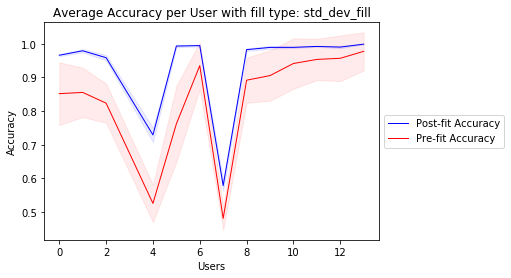

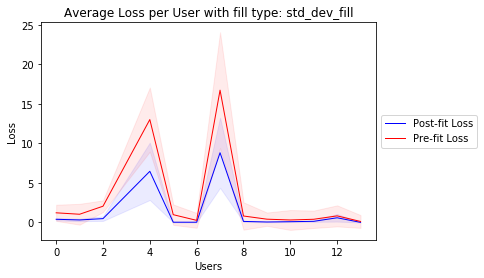

<Figure size 432x288 with 0 Axes>

In [77]:
def plot_avg_user_stats(users, std_dev_fill = False, min_max_fill = False, \
                        loss = False, accuracy = False, pre = True, post = True,
                        ignore_first_n = 0):
    if (loss == accuracy) or (std_dev_fill and min_max_fill):
        print("Please select one from accuracy or loss and one or nonefrom std_dev_fill or min_max_fill")
        return None
    # get the data for the prints ready
    metric = "Accuracy"
    if loss:
        metric = "Loss"
    
    fill_type = None
    if std_dev_fill:
        fill_type = "std_dev_fill"
    elif min_max_fill:
        fill_type = "min_max_fill"
    
    
    # data collection into df
    cols = ["Position", "User", "Average", "Standard Deviation", "Minimum", "Maximum"]
    df = pd.DataFrame(columns = cols)
    df_index = 0    
    for i, user in users.items():
        if post:
            user_data = user.get_data(ignore_first_n = ignore_first_n, 
                                      loss = loss, 
                                      accuracy = accuracy, 
                                      post = post)
            avg = np.average(user_data)
            std_dev = np.std(user_data)
            mini = np.amin(user_data)
            maxi = np.amax(user_data)
            df.loc[df_index] = ["Post", i, avg, std_dev, mini, maxi]
            df_index +=1
        if pre:
            user_data = user.get_data(ignore_first_n = ignore_first_n, 
                                      loss = loss, 
                                      accuracy = accuracy, 
                                      pre= pre)
            avg = np.average(user_data)
            std_dev = np.std(user_data)
            mini = np.amin(user_data)
            maxi = np.amax(user_data)
            df.loc[df_index] = ["Pre", i, avg, std_dev, mini, maxi]
            df_index +=1    
            
    # plot here and then fill here
    user_ids = list(users.keys())
    if post:
        position = "Post-fit"
        
        avg = df[df["Position"]=="Post"]["Average"]
        
        plt.plot(user_ids, avg, "b", linewidth = 1, label = f"{position} {metric}")
        
        if std_dev_fill:
            std_dev = df[df["Position"]=="Post"]["Standard Deviation"]
            plt.fill_between(user_ids,
                             avg - std_dev, 
                             avg + std_dev, 
                             alpha=0.08, color = "b")
        elif min_max_fill:
            mini = df[df["Position"]=="Post"]["Minimum"]
            maxi = df[df["Position"]=="Post"]["Maximum"]
            plt.fill_between(user_ids,
                             maxi, 
                             avg, 
                             alpha=0.08, color = "b")
            plt.fill_between(user_ids,
                             avg, 
                             mini, 
                             alpha=0.08, color = "b")
    if pre:
        position = "Pre-fit"
        
        avg = df[df["Position"]=="Pre"]["Average"]
        
        plt.plot(user_ids, avg, "r", linewidth = 1, label = f"{position} {metric}")
        
        if std_dev_fill:
            std_dev = df[df["Position"]=="Pre"]["Standard Deviation"]
            plt.fill_between(user_ids, 
                             avg - std_dev, 
                             avg + std_dev, 
                             alpha=0.08, color = "r")
        elif min_max_fill:
            mini = df[df["Position"]=="Pre"]["Minimum"]
            maxi = df[df["Position"]=="Pre"]["Maximum"]
            plt.fill_between(user_ids,
                             maxi, 
                             avg, 
                             alpha=0.08, color = "r")
            plt.fill_between(user_ids,
                             avg, 
                             mini, 
                             alpha=0.08, color = "r")
    
    
    plt.xlabel("Users")
    plt.ylabel(f"{metric}")
    plt.title(f"Average {metric} per User with fill type: {fill_type}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.clf()
    return df
a = plot_avg_user_stats(users, ignore_first_n = 0, std_dev_fill = True, accuracy = True)
a = plot_avg_user_stats(users, ignore_first_n = 0, std_dev_fill = True, loss = True)
# plot_avg_user_stats(users, post = True, pre=True, accuracy = True)


[5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78
 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 27

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

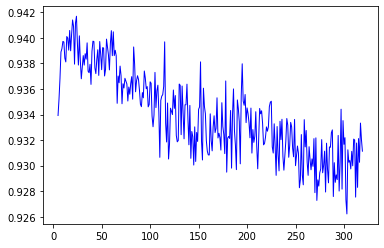

In [79]:
def plot_avg_round_stats(users, std_dev_fill = False, min_max_fill = False, \
                        loss = False, accuracy = False, pre = True, post = True,
                        ignore_first_n = 0):
    if (loss == accuracy) or (std_dev_fill and min_max_fill):
        print("Please select one from accuracy or loss and one or nonefrom std_dev_fill or min_max_fill")
        return None
    # get the data for the prints ready
    metric = "Accuracy"
    if loss:
        metric = "Loss"
    
    fill_type = None
    if std_dev_fill:
        fill_type = "std_dev_fill"
    elif min_max_fill:
        fill_type = "min_max_fill"
    
    
    # data collection into df
    cols = ["Position", "Round", "Average", "Standard Deviation", "Minimum", "Maximum"]
    df = pd.DataFrame(columns = cols)
    if post:
        user_data_post = []
        for i, user in users.items():
            user_data = user.get_data(ignore_first_n = ignore_first_n, 
                                      loss = loss, 
                                      accuracy = accuracy, 
                                      post = post)
            user_data_post.append(user_data)
        user_data_post = np.asarray(user_data_post)
        rounds = len(user_data_post[0])
        post_avg = np.average(user_data_post, axis = 0)
        post_std_dev = np.std(user_data_post,  axis = 0)
        post_mini = np.amin(user_data_post, axis = 0)
        post_maxi = np.amax(user_data_post, axis = 0)
    if pre:
        user_data_pre = []
        for i, user in users.items():
            user_data = user.get_data(ignore_first_n = ignore_first_n, 
                                      loss = loss, 
                                      accuracy = accuracy, 
                                      pre= pre)
            user_data_pre.append(user_data)
        user_data_pre = np.asarray(user_data_pre)
        rounds = len(user_data_pre[0])
        pre_avg = np.average(user_data_pre, axis = 0)
        pre_std_dev = np.std(user_data_pre, axis = 0)
        pre_mini = np.amin(user_data_pre, axis = 0)
        pre_maxi = np.amax(user_data_pre, axis = 0)
        
    
    rounds = [i for i in range(rounds)]
    df_index = 0
    for rnd in rounds:
        if pre:
            df.loc[df_index] = ["Pre", rnd+ignore_first_n, pre_avg[rnd], pre_std_dev[rnd], pre_mini[rnd], pre_maxi[rnd]]
            df_index +=1
        
        if post:
            df.loc[df_index] = ["Post", rnd+ignore_first_n, post_avg[rnd], post_std_dev[rnd], post_mini[rnd], post_maxi[rnd]]
            df_index +=1    
    # plot here and then fill here
    if post:
        position = "Post-fit"
        
        avg = df[df["Position"]=="Post"]["Average"]
        rounds = df["Round"].unique()
        print(rounds)
        plt.plot(rounds, avg, "b", linewidth = 1, label = f"{position} {metric}")
        
        if std_dev_fill:
            std_dev = df[df["Position"]=="Post"]["Standard Deviation"]
            plt.fill_between(rounds,
                             avg - std_dev, 
                             avg + std_dev, 
                             alpha=0.08, color = "b")
        elif min_max_fill:
            mini = df[df["Position"]=="Post"]["Minimum"]
            maxi = df[df["Position"]=="Post"]["Maximum"]
            plt.fill_between(rounds,
                             maxi, 
                             avg, 
                             alpha=0.08, color = "b")
            plt.fill_between(rounds,
                             avg, 
                             mini, 
                             alpha=0.08, color = "b")
    if pre:
        position = "Pre-fit"
        
        avg = df[df["Position"]=="Pre"]["Average"]
        rounds = df["Round"].unique()
        plt.plot(rounds, avg, "r", linewidth = 1, label = f"{position} {metric}")
        
        if std_dev_fill:
            std_dev = df[df["Position"]=="Pre"]["Standard Deviation"]
            plt.fill_between(rounds, 
                             avg - std_dev, 
                             avg + std_dev, 
                             alpha=0.08, color = "r")
        elif min_max_fill:
            mini = df[df["Position"]=="Pre"]["Minimum"]
            maxi = df[df["Position"]=="Pre"]["Maximum"]
            plt.fill_between(rounds,
                             maxi, 
                             avg, 
                             alpha=0.08, color = "r")
            plt.fill_between(rounds,
                             avg, 
                             mini, 
                             alpha=0.08, color = "r")
    
    
    plt.xlabel("Rounds")
    plt.ylabel(f"{metric}")
    plt.title(f"Average {metric} per Round with fill type: {fill_type}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.clf()
    return df
a = plot_avg_round_stats(users, min_max_fill = True, ignore_first_n = 5, accuracy = True)
a = plot_avg_round_stats(users, ignore_first_n = 5, loss = True)
# plot_avg_user_stats(users, post = True, pre=True, accuracy = True)
